In [1]:
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive')
!wget http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/horse2zebra.zip
!unzip horse2zebra.zip
!rm horse2zebra.zip
clear_output()

In [2]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from glob import glob
from tqdm.notebook import tqdm
from itertools import chain

torch.random.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)

In [3]:
horses_train = glob('horse2zebra/trainA/'+'/*')
zebras_train = glob('horse2zebra/trainB/'+'/*')

horses_test = glob('horse2zebra/testA/'+'/*')
zebras_test = glob('horse2zebra/testB/'+'/*')

horses_train, zebras_train, horses_test, zebras_test = [np.array([str(i) for i in j]) for j in [horses_train, zebras_train, horses_test, zebras_test]]
len(horses_train), len(zebras_train), len(horses_test), len(zebras_test)

(1067, 1334, 120, 140)

In [4]:
""" # if validation is needed
from sklearn.model_selection import train_test_split

horses_train, horses_valid = train_test_split(horses_train, test_size=0.1, shuffle=True, random_state=123)
zebras_train, zebras_valid = train_test_split(zebras_train, test_size=0.15, shuffle=True, random_state=123)
len(horses_train), len(horses_valid), len(zebras_train), len(zebras_valid), len(horses_test), len(zebras_test)
"""

' # if validation is needed\nfrom sklearn.model_selection import train_test_split\n\nhorses_train, horses_valid = train_test_split(horses_train, test_size=0.1, shuffle=True, random_state=123)\nzebras_train, zebras_valid = train_test_split(zebras_train, test_size=0.15, shuffle=True, random_state=123)\nlen(horses_train), len(horses_valid), len(zebras_train), len(zebras_valid), len(horses_test), len(zebras_test)\n'

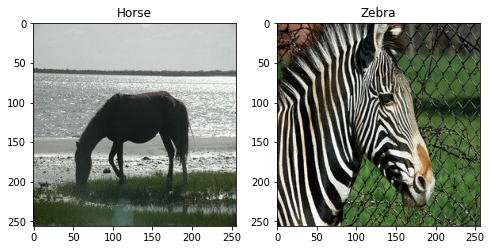

In [5]:
plt.figure(figsize=(8,6))
plt.subplot(121)
plt.title('Horse')
horse = cv2.imread(horses_train[np.random.randint(len(horses_train))])
horse = cv2.cvtColor(horse, cv2.COLOR_BGR2RGB)
plt.imshow(horse)
plt.subplot(122)
plt.title('Zebra')
zebra = cv2.imread(zebras_train[np.random.randint(len(zebras_train))])
zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)
plt.imshow(zebra)
plt.show()

In [6]:
IMAGE_SIZE = 256
BATCH_SIZE = 2 
epochs = 40
PATH = r'/content/drive/My Drive/data/cycle_GAN.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
transforms = T.Compose([
                        T.ToPILImage(),
                        T.Resize(int(IMAGE_SIZE*1.13)),
                        T.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)),
                        T.RandomHorizontalFlip(p=0.2),
                        T.ToTensor(),
                        T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [8]:
class HorseToZebra(Dataset):
    def __init__(self, horses, zebras, transforms):
        self.horses = horses
        self.zebras = zebras
        self.transforms = transforms

    def __len__(self):
        return max(len(self.horses), len(self.zebras))

    def __getitem__(self, ix):
        horse = self.horses[ix % len(self.horses)]
        zebra = self.zebras[np.random.randint(len(self.zebras))]
        horse = cv2.imread(horse)
        horse = cv2.cvtColor(horse, cv2.COLOR_BGR2RGB)
        zebra = cv2.imread(zebra)
        zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)
        return horse, zebra

    def collate_fn(self, batch):
        horses, zebras = list(zip(*batch))
        horses = torch.cat([self.transforms(img)[None].float().to(device) for img in horses], 0)
        zebras = torch.cat([self.transforms(img)[None].float().to(device) for img in zebras], 0)
        return horses, zebras

In [9]:
def weights_init(obj):
    classname = obj.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(obj.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(obj.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(obj.bias.data, 0.0)

def load_test_tensor(test_array: np.array = horses_test):
    image_idx = np.random.randint(len(test_array))
    image = cv2.imread(test_array[image_idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = transforms(image)[None].float().to(device)
    return image, image_tensor

invTrans = T.Compose([T.Normalize(mean = [ 0., 0., 0. ],
                                      std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                          T.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                      std = [ 1., 1., 1. ]),
                          T.ToPILImage(),
                         ])

In [10]:
train_dataset = HorseToZebra(horses_train, zebras_train, transforms)
# valid_dataset = HorseToZebra(horses_valid, zebras_valid, transforms)  # uncomment if validation needed

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=train_dataset.collate_fn)

# valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=valid_dataset.collate_fn)

#### Different architecture modifications

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
        )
    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(Generator, self).__init__()
        out_features = 64
        channels = 3
        model = [
                 nn.ReflectionPad2d(3),
                 nn.Conv2d(channels, out_features, kernel_size=7, stride=1, padding=0),
                 nn.InstanceNorm2d(out_features),
                 nn.ReLU(inplace=True),
        ]

        in_features = out_features
        for _ in range(2):
            out_features *= 2
            model += [
                      nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True),
            ]
            in_features = out_features

        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        for _ in range(2):
            out_features //= 2
            model += [
                      nn.Upsample(scale_factor=2),
                      nn.Conv2d(in_features, out_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True)
            ]
            in_features = out_features
        
        model += [
                  nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, kernel_size=7, stride=1, padding=0),
                  nn.Tanh(),
        ]
        self.model = nn.Sequential(*model)
        self.apply(weights_init)
    
    def forward(self, x):
        return self.model(x)

class Identity(nn.Module):
    def forward(self, x):
        return x

def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'none':
        def norm_layer(x): return Identity()
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

class Discriminator(nn.Module):
    def __init__(self):
        norm_layer = get_norm_layer()
        super(Discriminator, self).__init__()
        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE
        
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [
                      nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, kernel_size=4, stride=2, padding=1)),
            ]
            if normalize:
                layers.append(norm_layer(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
        )
        self.apply(weights_init)

    def forward(self, x):
        return self.model(x)

In [12]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=3, n_output=3, size=256, pretrained=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=pretrained, n_in=n_input)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

class Generator(nn.Module):
    def __init__(self, pretrained=False):
        super(Generator, self).__init__()
        self.backbone = build_res_unet(pretrained=pretrained)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.tanh(self.backbone(x))
        out = x + out
        out = torch.clamp(out, min=-1, max=1)
        return out

In [13]:
import functools

class UnetGenerator(nn.Module):

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):

        super(UnetGenerator, self).__init__()

        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)
        for i in range(num_downs - 5):          
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)

        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer) 

    def forward(self, input):
        return self.model(input)


class UnetSkipConnectionBlock(nn.Module):

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else: 
            return torch.cat([x, self.model(x)], 1)

In [14]:
# G_AB = Generator().to(device)
# G_BA = Generator().to(device)
G_AB = UnetGenerator(3, 3, 8, 64, norm_layer=get_norm_layer(), use_dropout=False).apply(weights_init).to(device)
G_BA = UnetGenerator(3, 3, 8, 64, norm_layer=get_norm_layer(), use_dropout=False).apply(weights_init).to(device)

D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

summary(G_AB, (3, IMAGE_SIZE, IMAGE_SIZE))
print()
summary(D_A, (3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 64, 64]         131,200
    InstanceNorm2d-4          [-1, 128, 64, 64]               0
         LeakyReLU-5          [-1, 128, 64, 64]               0
            Conv2d-6          [-1, 256, 32, 32]         524,544
    InstanceNorm2d-7          [-1, 256, 32, 32]               0
         LeakyReLU-8          [-1, 256, 32, 32]               0
            Conv2d-9          [-1, 512, 16, 16]       2,097,664
   InstanceNorm2d-10          [-1, 512, 16, 16]               0
        LeakyReLU-11          [-1, 512, 16, 16]               0
           Conv2d-12            [-1, 512, 8, 8]       4,194,816
   InstanceNorm2d-13            [-1, 512, 8, 8]               0
        LeakyReLU-14            [-1, 51

In [15]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()
# to improve: we may use WGAN-Loss as GAN-loss function

lambda_cycle, lambda_identity = 10.0, 5.0

optimizer_G = optim.Adam(chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)
optimizer_DA = optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)
optimizer_DB = optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-7)

scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=20, gamma=0.1, verbose=True)
scheduler_DA = optim.lr_scheduler.StepLR(optimizer_DA, step_size=20, gamma=0.1, verbose=True)
scheduler_DB = optim.lr_scheduler.StepLR(optimizer_DB, step_size=20, gamma=0.1, verbose=True)

Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.
Adjusting learning rate of group 0 to 2.0000e-04.


In [16]:
def save_model(checkpoint, path=PATH):
    torch.save(checkpoint, path)
    print(f'Model saved to: {path}')

def load_model(path=PATH, device=device):
    checkpoint = torch.load(path, map_location=device)
    epoch = checkpoint['epoch']
    G_AB = checkpoint['G_AB']
    G_BA = checkpoint['G_BA']
    optimizer_G = checkpoint['optimizer_G']
    D_A = checkpoint['D_A']
    D_B = checkpoint['D_B']
    optimizer_DA = checkpoint['optimizer_DA']
    optimizer_DB = checkpoint['optimizer_DB']
    scheduler_G = checkpoint['scheduler_G']
    scheduler_DA = checkpoint['scheduler_DA']
    scheduler_DB = checkpoint['scheduler_DB']    
    return epoch, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_DA, optimizer_DB, scheduler_G, scheduler_DA, scheduler_DB

In [17]:
def generator_train_step(G_AB, G_BA, optimizer, real_A, real_B):
    G_AB.train()
    G_BA.train()
    optimizer.zero_grad()

    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)
    loss_identity = (loss_id_A + loss_id_B) / 2

    fake_B = G_AB(real_A)
    loss_gan_AB = criterion_GAN(D_B(fake_B), torch.ones((len(real_A), 1, 16, 16)).to(device))
    fake_A = G_BA(real_B)
    loss_gan_BA = criterion_GAN(D_A(fake_A), torch.ones((len(fake_A), 1, 16, 16)).to(device))
    loss_gan = (loss_gan_AB + loss_gan_BA) / 2

    recon_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recon_A, real_A)
    recon_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recon_B, real_B)
    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

    loss_G = loss_gan + lambda_cycle * loss_cycle + lambda_identity * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_gan, loss_cycle, fake_A, fake_B

def discriminator_train_step(D, real_data, fake_data, optimizer):
    D.train()
    optimizer.zero_grad()

    loss_real = criterion_GAN(D(real_data), torch.ones((len(real_data), 1, 16, 16)).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.zeros((len(fake_data), 1, 16, 16)).to(device))
    loss_D = (loss_real + loss_fake) / 2

    loss_D.backward()
    optimizer.step()
    return loss_D

@torch.no_grad()
def show_evaluation(G_AB, G_BA, horses, zebras):
    G_AB.eval()
    G_BA.eval()
    horse, horse_tensor = load_test_tensor()
    zebra, zebra_tensor = load_test_tensor(zebras_test)
    fake_zebra = G_AB(horse_tensor)
    fake_horse = G_BA(zebra_tensor)
    fake_horse = invTrans(fake_horse.squeeze())
    fake_zebra = invTrans(fake_zebra.squeeze())
    plt.figure(figsize=(13, 13))
    plt.subplot(221)
    plt.title('True horse')
    plt.imshow(horse)
    plt.subplot(222)
    plt.title('Fake zebra')
    plt.imshow(fake_zebra)
    plt.subplot(223)
    plt.title('True zebra')
    plt.imshow(zebra)
    plt.subplot(224)
    plt.title('Fake horse')
    plt.imshow(fake_horse)
    plt.show()
    plt.pause(0.001)

Epoch 39/40


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Epoch G-loss: 1.0084, epoch D-loss: 0.1530, epoch GAN-loss: 0.4997
--------------------------------------------------
Epoch 40/40


  0%|          | 0/667 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Adjusting learning rate of group 0 to 2.0000e-06.
Epoch G-loss: 1.0114, epoch D-loss: 0.1507, epoch GAN-loss: 0.5050
--------------------------------------------------
Model saved to: /content/drive/My Drive/data/cycle_GAN.pth


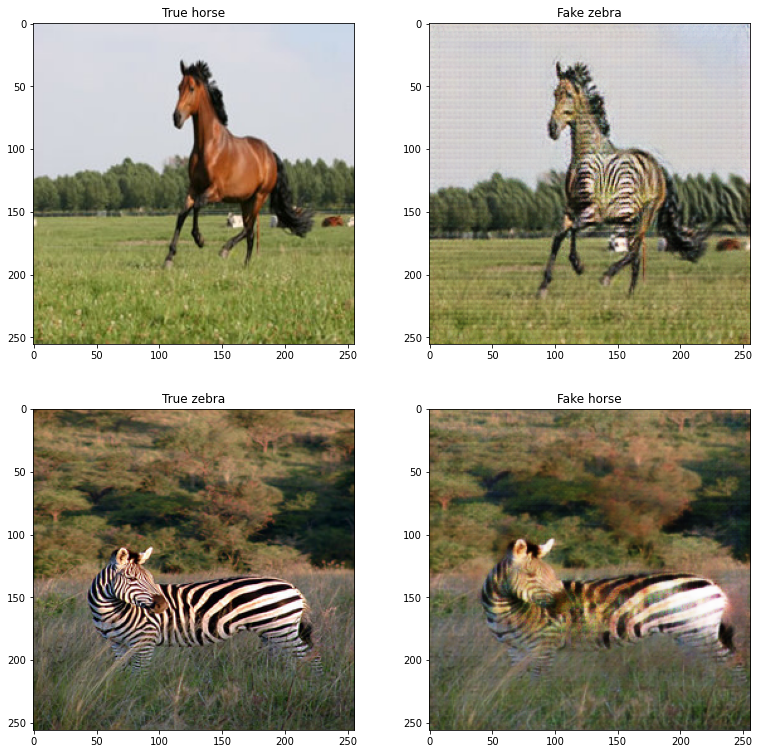

In [21]:
losses_GAN, losses_D, losses_G = [], [], []

try:
    ep, G_AB, G_BA, D_A, D_B, optimizer_G, optimizer_DA, optimizer_DB, scheduler_G, scheduler_DA, scheduler_DB = load_model(PATH)
    ep += 1
except Exception:
    ep = 0

for epoch in range(ep, epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_gan_loss, epoch_D_loss, epoch_G_loss = [], [], []
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        real_A, real_B = batch
        loss_G, loss_identity, loss_GAN, loss_cycle, fake_A, fake_B = generator_train_step(G_AB, G_BA, 
                                                                                           optimizer_G,
                                                                                           real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_DA)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_DB)
        loss_D = (loss_D_A + loss_D_B) / 2
        epoch_gan_loss.append(loss_GAN.item())
        epoch_D_loss.append(loss_D.item())
        epoch_G_loss.append(loss_G.item())
    loss_G_value = np.array(epoch_G_loss).mean()
    loss_D_value = np.array(epoch_D_loss).mean()
    loss_GAN_value = np.array(epoch_gan_loss).mean()
    losses_G.append(loss_G_value)
    losses_D.append(loss_D_value)
    losses_GAN.append(loss_GAN_value)
    scheduler_G.step()
    scheduler_DA.step()
    scheduler_DB.step()
    print(f'Epoch G-loss: {loss_G_value:.4f}, epoch D-loss: {loss_D_value:.4f}, epoch GAN-loss: {loss_GAN_value:.4f}')
    print('-'*50)
    if (epoch + 1) % 2 == 0:
        checkpoint = { 
                  'epoch': epoch,
                  'G_AB': G_AB,
                  'G_BA': G_BA,
                  'optimizer_G': optimizer_G,
                  'D_A': D_A,
                  'D_B': D_B,
                  'optimizer_DA': optimizer_DA,
                  'optimizer_DB': optimizer_DB,
                  'scheduler_G': scheduler_G,
                  'scheduler_DA': scheduler_DA,
                  'scheduler_DB': scheduler_DB,
                  }
        save_model(checkpoint)
        show_evaluation(G_AB, G_BA, horses_test, zebras_test)

In [40]:
@torch.no_grad()
def show_evaluation(G_AB, G_BA, horses, zebras):
    G_AB.eval()
    G_BA.eval()
    horse, horse_tensor = load_test_tensor()
    zebra, zebra_tensor = load_test_tensor(zebras_test)
    fake_zebra = G_AB(horse_tensor)
    fake_zebra = invTrans(fake_zebra.squeeze())
    plt.figure(figsize=(13, 13))
    plt.subplot(221)
    plt.title('True horse')
    plt.imshow(horse)
    plt.subplot(222)
    plt.title('Fake zebra')
    plt.imshow(fake_zebra)
    plt.show()
    plt.pause(0.001)

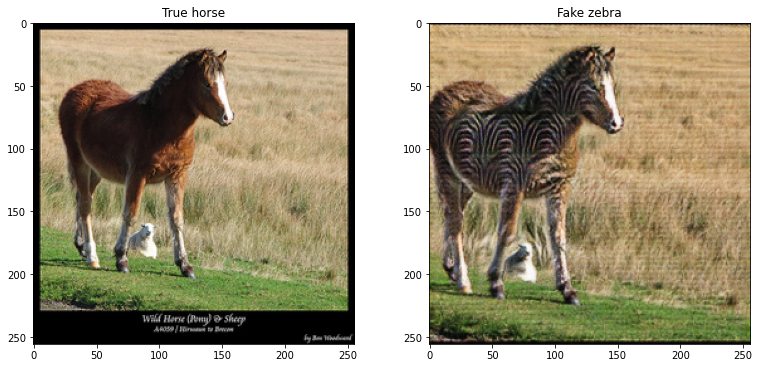

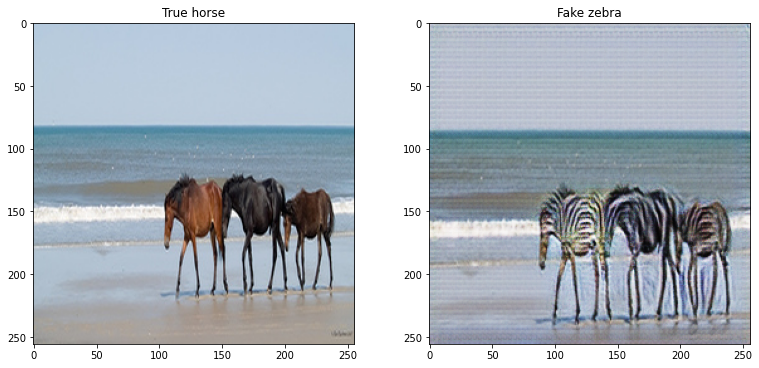

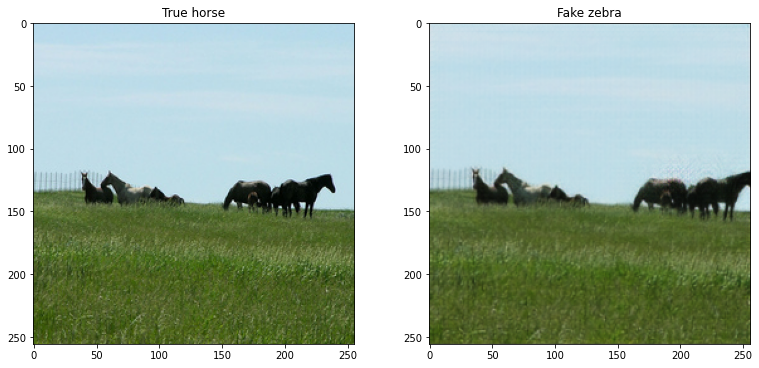

In [48]:
for _ in range(3):
    show_evaluation(G_AB, G_BA, horses_test, zebras_test)